# Interoperability with R and Seurat


In this tutorial, we go over how to use basic scvi-tools functionality in R. However, for more involved analyses, we suggest using scvi-tools from Python. Checkout the [Scanpy_in_R tutorial](https://theislab.github.io/scanpy-in-R/#converting-from-r-to-python-1) for instructions on converting Seurat objects to anndata. 

This tutorial requires Reticulate. Please check out our installation [guide](https://www.scvi-tools.org/en/latest/installation.html#scvi-tools-installation-for-R) for instructions on installing Reticulate and scvi-tools.

## Loading and processing data with Seurat
We follow the basic Seurat [tutorial](https://satijalab.org/seurat/v3.2/pbmc3k_tutorial.html) for loading data and selecting highly variable genes.

**Note: scvi-tools requires raw gene expression**

In [1]:
# install.packages("Seurat")
# install.packages("reticulate")
# install.packages("cowplot")
# install.packages("devtools")

# devtools::install_github("satijalab/seurat-data")
# SeuratData::InstallData("pbmc3k")
# install.packages("https://seurat.nygenome.org/src/contrib/ifnb.SeuratData_3.0.0.tar.gz", repos = NULL, type = "source") 
# SeuratData::InstallData("ifnb")

# devtools::install_github("cellgeni/sceasy")

In [2]:
# We will work within the Seurat framework
library(Seurat)
suppressWarnings(library(SeuratData))
data("pbmc3k")
pbmc <- pbmc3k

pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
top2000 <- head(VariableFeatures(pbmc), 2000)
pbmc <- pbmc[top2000]


print(pbmc) # Seurat object

Attaching SeuratObject

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

── Installed datasets ────────────────────────────────────────────────────────────────────────────────────────── SeuratData v0.2.1 ──

✔ ifnb   3.0.0                                                    ✔ pbmc3k 3.1.4


──────────────────────────────────────────────────────────────── Key ────────────────────────────────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed




An object of class Seurat 
2000 features across 2638 samples within 1 assay 
Active assay: RNA (2000 features, 2000 variable features)


## Converting Seurat object to AnnData

scvi-tools relies on the [AnnData](https://anndata.readthedocs.io/en/latest/) object. Here we show how to convert our Seurat object to anndata for scvi-tools.



In [3]:
library(reticulate)
library(sceasy)

sc <- import("scanpy", convert = FALSE)
scvi <- import("scvi", convert = FALSE)

In [4]:
adata <- sceasy::convertFormat(pbmc, from="seurat", to="anndata", main_layer="counts", drop_single_values=FALSE)
print(adata) # Note generally in Python, dataset conventions are obs x var

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_annotations', 'percent.mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'


## Setup our AnnData for training

Reticulate allows us to call Python code from R, giving the ability to use all of scvi-tools in R. We encourage you to checkout their [documentation](https://rstudio.github.io/reticulate/articles/calling_python.html) and specifically the section on type conversions in order to pass arguments to Python functions.

In this section, we show how to setup the AnnData for scvi-tools, create the model, train the model, and get the latent representation. For a more in depth description of setting up the data, you can checkout our [introductory tutorial](https://www.scvi-tools.org/en/latest/user_guide/notebooks/api_overview.html) as well as our [data loading tutorial](https://www.scvi-tools.org/en/latest/user_guide/notebooks/data_loading.html). 


In [5]:
# run setup_anndata
scvi$data$setup_anndata(adata)

# create the model
model = scvi$model$SCVI(adata)

# train the model
model$train()

# to specify the number of epochs when training:
# model$train(max_epochs = as.integer(400))


None

None

## Getting the latent represenation and visualization
Here we get the latent representation of the model and save it back in our Seurat object. Then we run UMAP and visualize. 

In [6]:
# get the latent represenation
latent = model$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(pbmc)
pbmc[["scvi"]] <- suppressWarnings(CreateDimReducObject(embeddings = latent, key = "scvi_", assay = DefaultAssay(pbmc)))


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 92924

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7247
Number of communities: 8
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


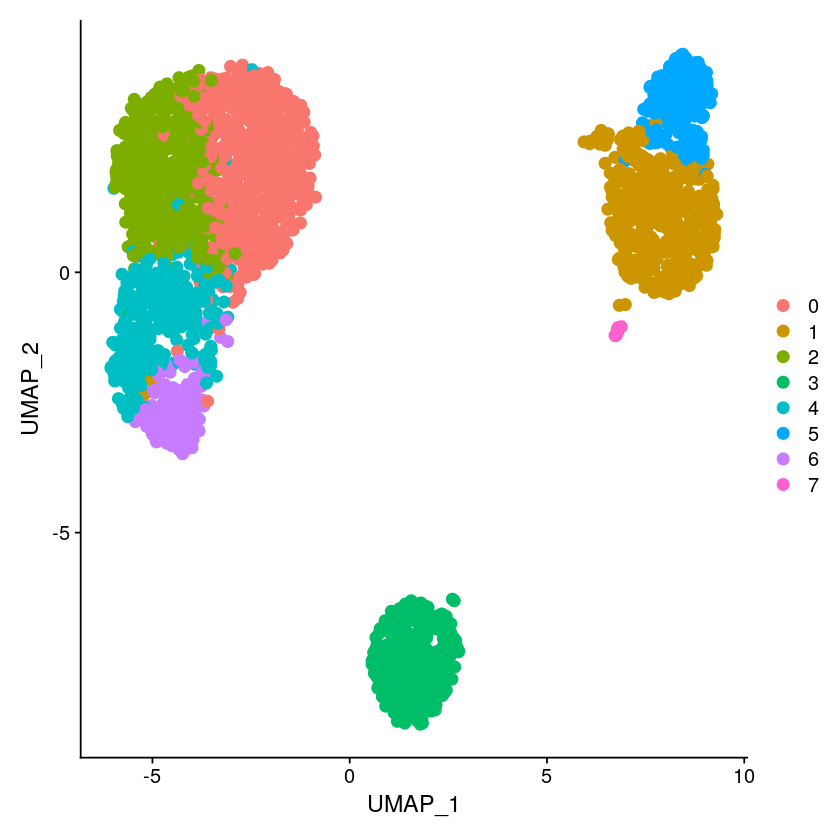

In [7]:
# Find clusters, then run UMAP, and visualize
pbmc <- FindNeighbors(pbmc, dims = 1:10, reduction = "scvi")
pbmc <- FindClusters(pbmc, resolution =1)

pbmc <- suppressMessages(RunUMAP(pbmc, dims = 1:10, reduction = "scvi", n.components = 2))

DimPlot(pbmc, reduction = "umap", pt.size = 3)


## Finding differentially expressed genes with scVI latent space

First, we put the seurat clusters into our original anndata.


In [8]:
adata$obs$insert(adata$obs$shape[1], "seurat_clusters", pbmc[["seurat_clusters"]][,1])

None

Using our trained SCVI model, we call the `differential_expression()` method
We pass `seurat_clusters` to the groupby argument and compare between cluster `1` and cluster `2`.

The output of DE is a DataFrame with the bayes factors. Bayes factors > 3 have high probability of being differentially expressed. You can also set fdr_target, which will return the differentially expressed genes based on the posteior expected FDR. 

In [9]:
DE <- model$differential_expression(adata, groupby="seurat_clusters", group1 = "1", group2 = "2")

In [10]:
print(DE$head())

        proba_de  proba_not_de  bayes_factor    scale1    scale2  ...  raw_normalized_mean2  is_de_fdr_0.05  comparison  group1  group2
IL7R      1.0000        0.0000     18.420681  0.000199  0.004355  ...             42.626759            True      1 vs 2       1       2
LTB       1.0000        0.0000     18.420681  0.000590  0.016834  ...            180.140244            True      1 vs 2       1       2
IL32      0.9998        0.0002      8.516943  0.000527  0.008710  ...             95.283165            True      1 vs 2       1       2
CST3      0.9998        0.0002      8.516943  0.015556  0.000561  ...              5.232877            True      1 vs 2       1       2
FCER1G    0.9996        0.0004      7.823621  0.004634  0.000376  ...              2.082036            True      1 vs 2       1       2

[5 rows x 22 columns]


## Integrating datasets with scVI

Here we integrate two datasets from Seurat's [Immune Alignment Vignette](https://satijalab.org/seurat/v3.2/immune_alignment.html).

In [11]:
data("ifnb")

# use seurat for variable gene selection 
ifnb <- NormalizeData(ifnb, normalization.method = "LogNormalize", scale.factor = 10000)
ifnb[["percent.mt"]] <- PercentageFeatureSet(ifnb, pattern = "^MT-")
ifnb <- subset(ifnb, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
ifnb <- FindVariableFeatures(ifnb, selection.method = "vst", nfeatures = 2000)
top2000 <- head(VariableFeatures(ifnb), 2000)
ifnb <- ifnb[top2000]

In [12]:
adata <- sceasy::convertFormat(ifnb, from="seurat", to="anndata", main_layer="counts", drop_single_values=FALSE)
print(adata)

AnnData object with n_obs × n_vars = 13997 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'percent.mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'


In [13]:
adata

AnnData object with n_obs × n_vars = 13997 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'percent.mt'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [14]:
# run setup_anndata, use column stim for batch
scvi$data$setup_anndata(adata, batch_key = 'stim')

# create the model
model = scvi$model$SCVI(adata)

# train the model
model$train()

# to specify the number of epochs when training:
# model$train(max_epochs = as.integer(400))


None

None

In [15]:
# get the latent represenation
latent = model$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(ifnb)
ifnb[["scvi"]] <- suppressWarnings(CreateDimReducObject(embeddings = latent, key = "scvi_", assay = DefaultAssay(ifnb)))

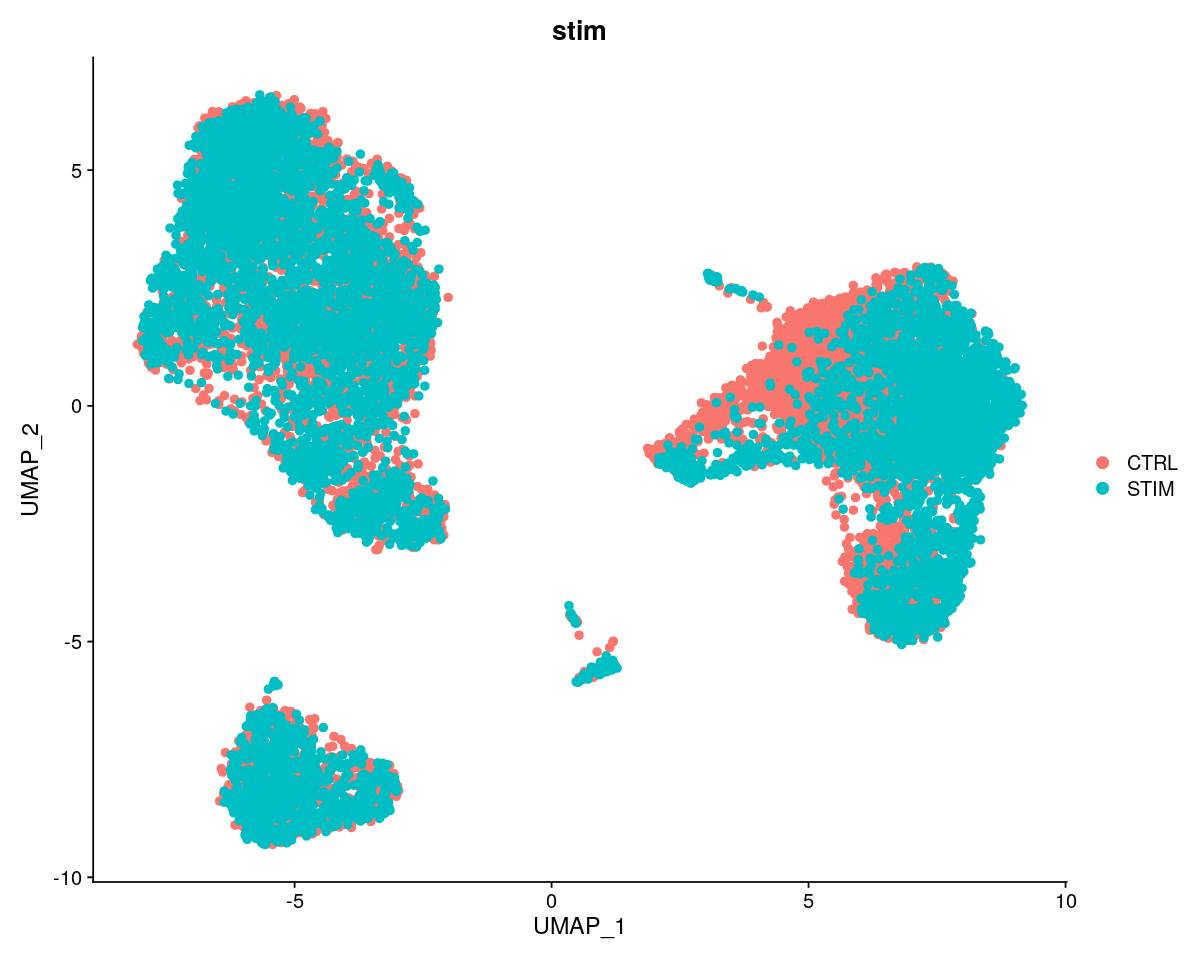

In [16]:
library(cowplot)
# for jupyter notebook
options(repr.plot.width=10, repr.plot.height=8)

ifnb <- suppressMessages(RunUMAP(ifnb, dims = 1:10, reduction = "scvi", n.components = 2))
p1 <- DimPlot(ifnb, reduction = "umap", group.by = "stim", pt.size=2)
plot_grid(p1)

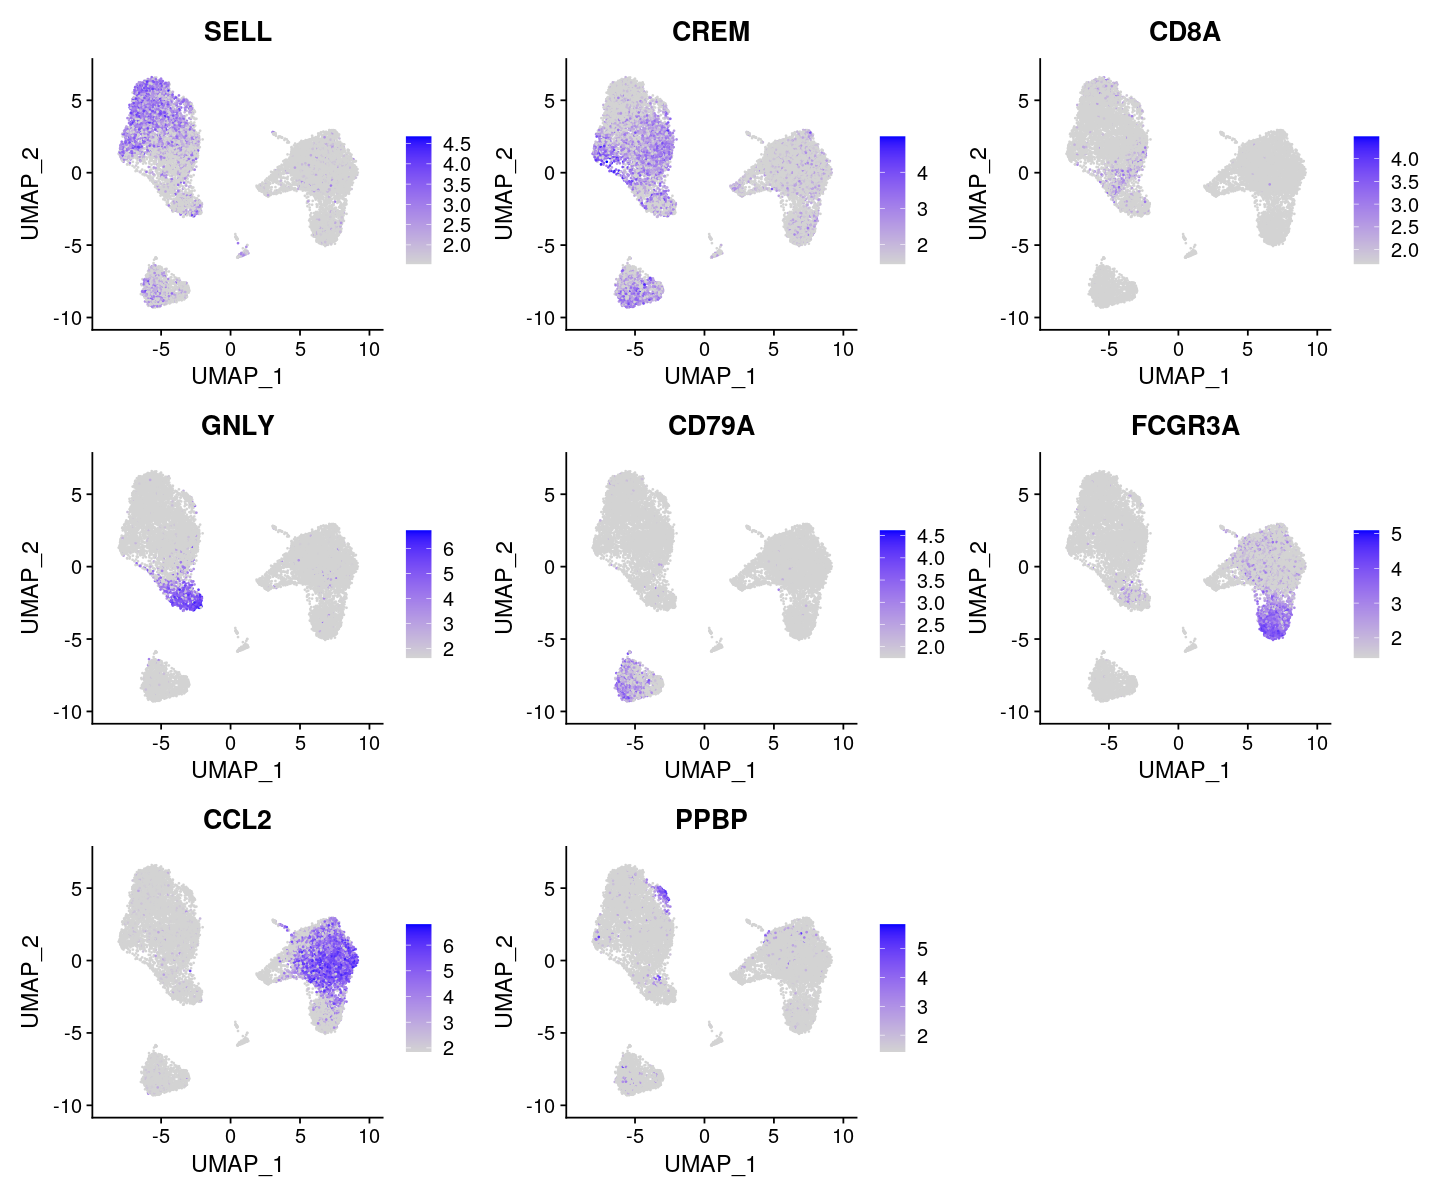

In [19]:
options(repr.plot.width=12, repr.plot.height=10)

FeaturePlot(ifnb, features = c("SELL", "CREM", "CD8A", "GNLY", "CD79A", "FCGR3A", 
    "CCL2", "PPBP"), min.cutoff = "q9")

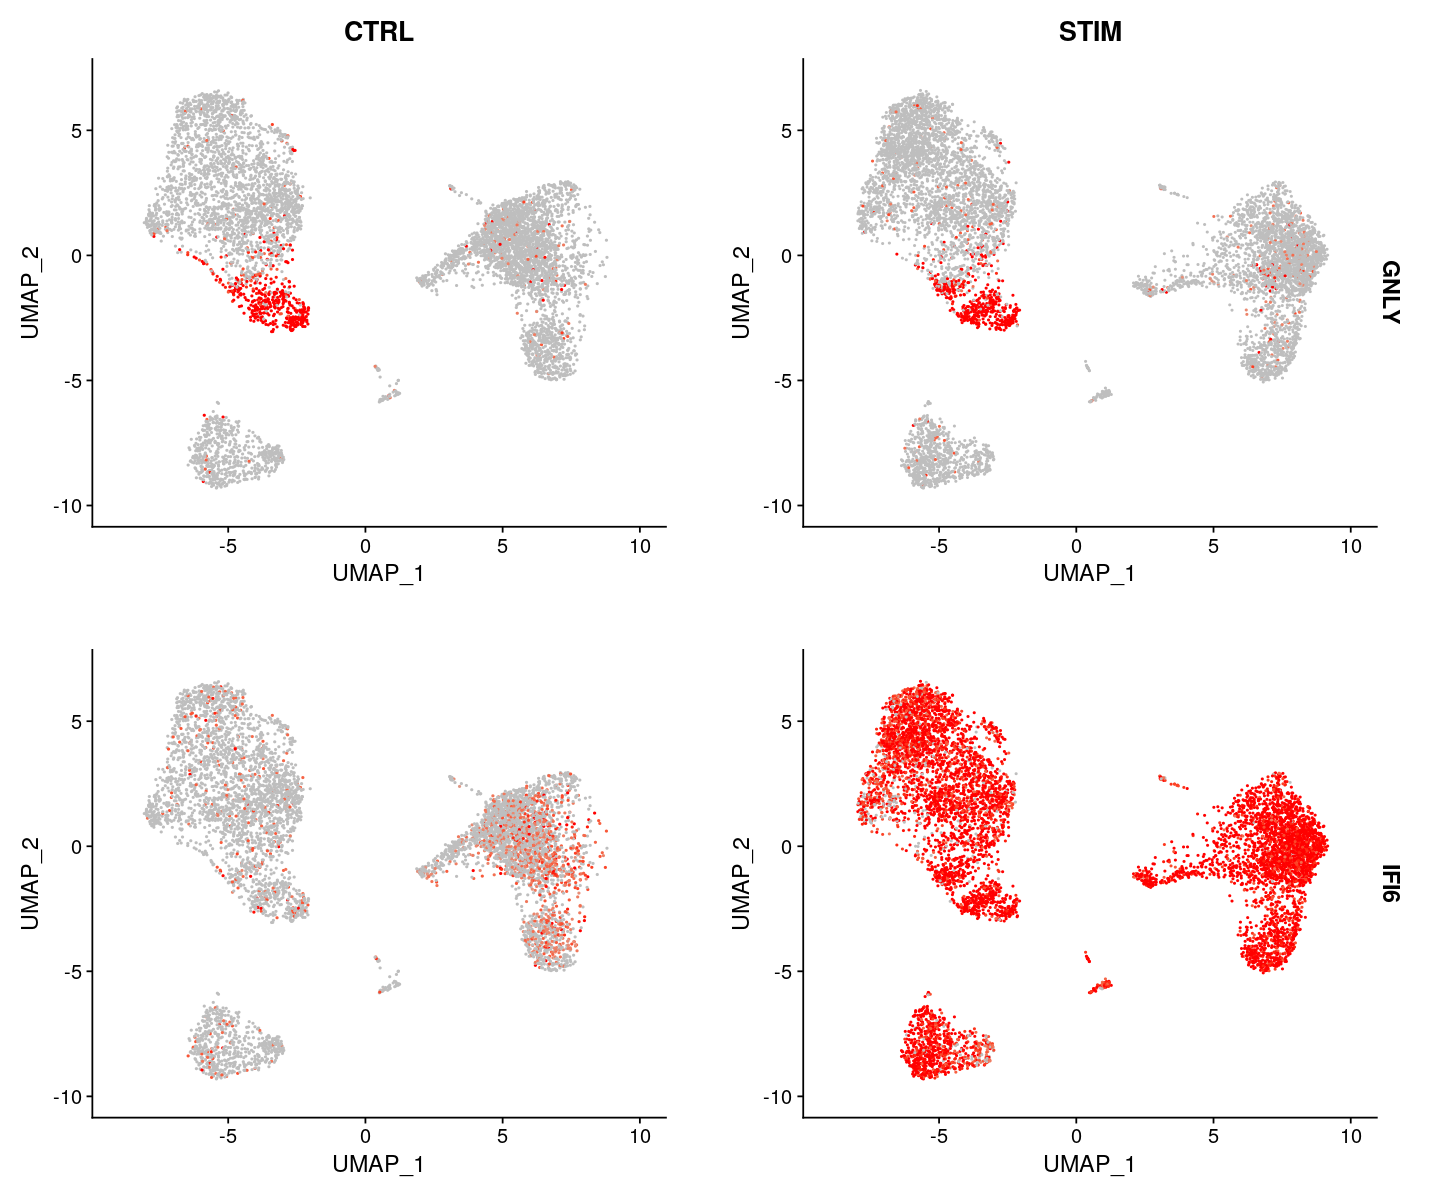

In [20]:
FeaturePlot(ifnb, features = c("GNLY", "IFI6"), split.by = "stim", max.cutoff = 3, 
    cols = c("grey", "red"))

#### Session Info Summary

In [54]:
sI <- sessionInfo()
sI$loadedOnly <- NULL
print(sI, locale=FALSE)

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /data/yosef2/users/jhong/miniconda3/envs/scrna_py_r/lib/libopenblasp-r0.3.12.so

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1           sceasy_0.0.6            reticulate_1.20        
[4] pbmc3k.SeuratData_3.1.4 ifnb.SeuratData_3.0.0   SeuratData_0.2.1       
[7] SeuratObject_4.0.2      Seurat_4.0.4           
